In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

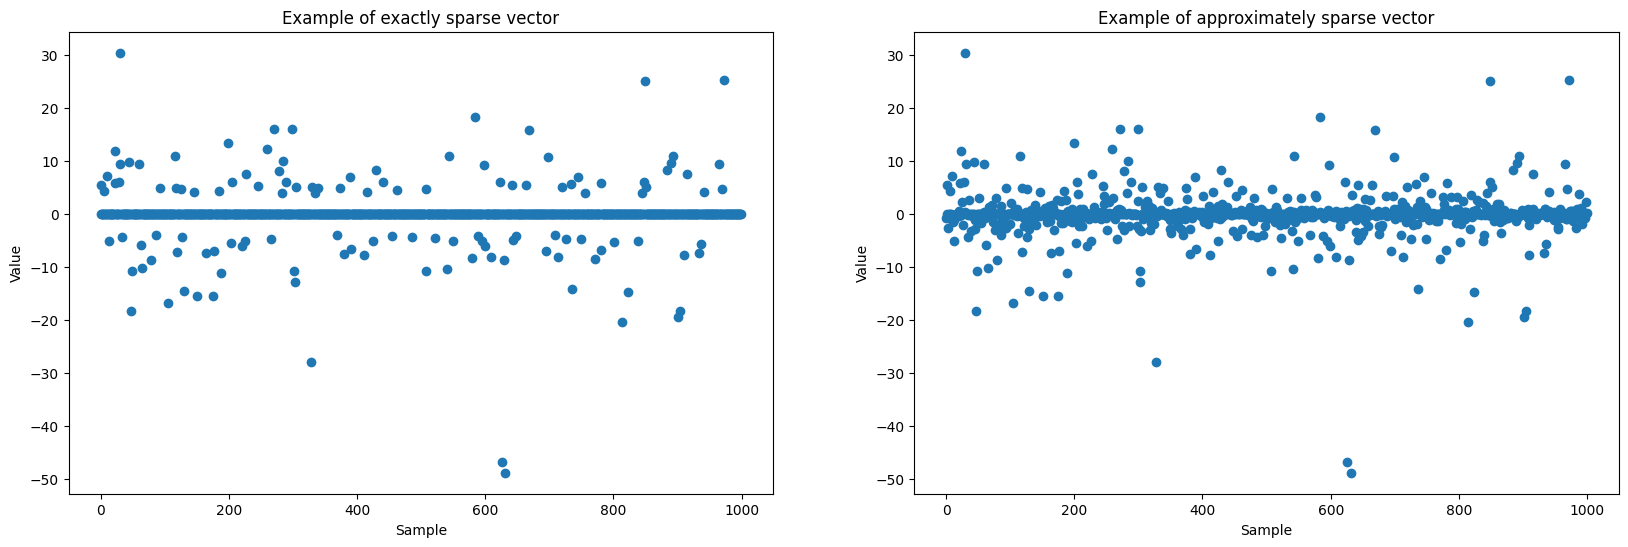

In [2]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

**Answer:** An exactly sparse signal is a signal in which only a few points are non zero. In an approximately sparse signal however, this condition becomes only a few points are greater than a set value $\delta$

Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

First, generate a simulated source S matrix. Plot the corresponding scatter plot. Interpret the shape of the scatter plot you obtain.

(-1.0948511587906011,
 1.0882535544372438,
 -1.099579592325502,
 1.0918131933408028)

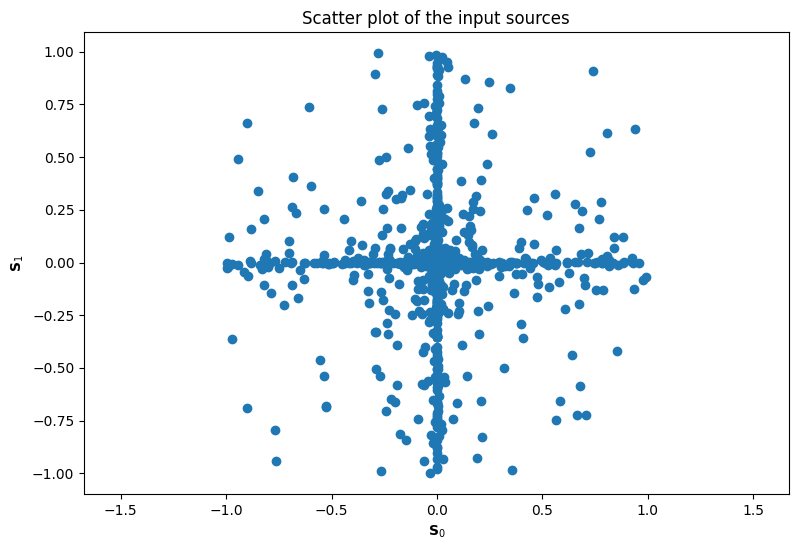

In [3]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 80 # noise level, in dB
power = 5 # power exponent used in the source generation



# TO DO : generate a simulated source S matrix.
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse
# law we used above.
S = (2*np.random.random((n,t))-1)**power # TO CHANGE

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal')

In [4]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 100

# To be more realistic, we add some noise to the mixing.
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120:
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

Plot the scatter plot of X. What do you see ?

What do the directions of the lines you observe correspond ?

Try several A matrices, noise_values and powers. Any comment?

**Answer:** We still see a cross shape scatterplot but the angle between the branches has changed and if we add a lot of noise, the cross shape is hard to make out. The directions of the lines are the new direction the equivalent line in S takes after being transformed by A.

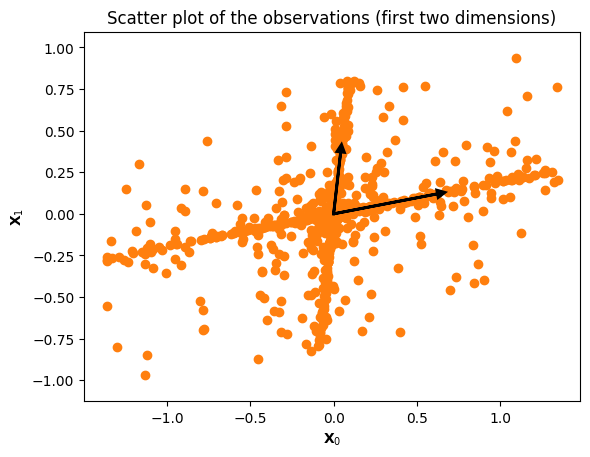

In [5]:
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals. The methodology extends to more complex datasets.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

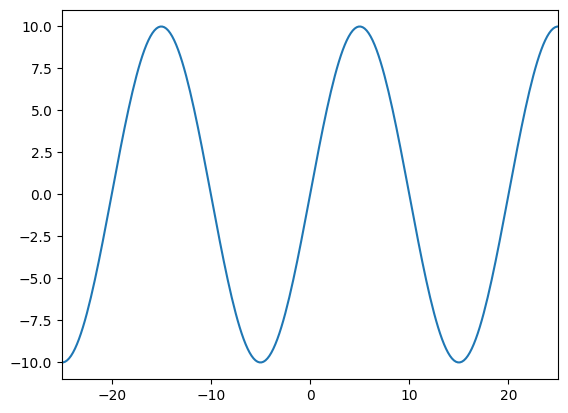

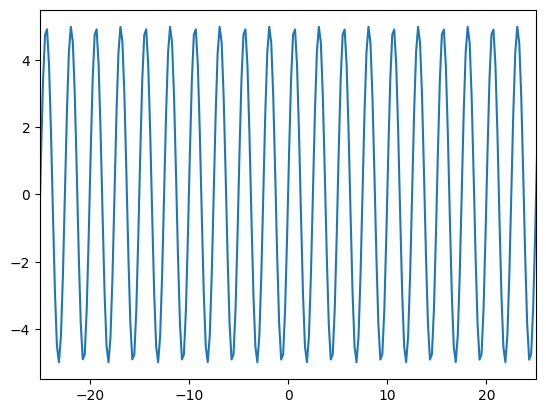

In [99]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

Here, we will transform the sources signals S into the DCT domain.

What is the objective of using the DCT?

Plot the above DCT and justify what you see. Pay attention to the labeling of the x-axis. Try with sines of various frequencies.

**Answer:** Since our signals are sines, their DCT transform is going to be a single spike centered on their frequency. Indeed we get a spike on 0.05 and 0.4 for the two signals.

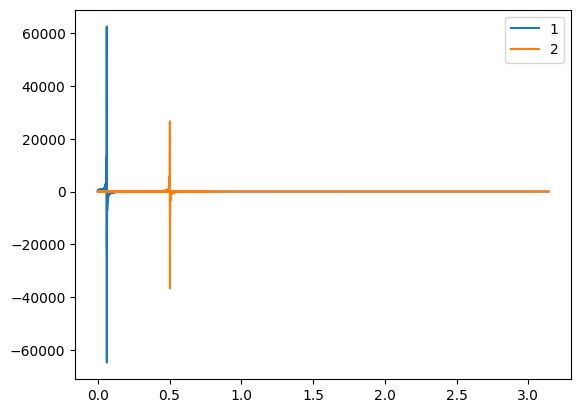

In [52]:
# Transformation into the DCT domain
Sf = sff.dct(S)
plt.plot(np.linspace(0,np.pi,t),Sf[0,:],label='1')
plt.plot(np.linspace(0,np.pi,t),Sf[1,:],label='2')
plt.legend()
plt.show()

Data generation : now, we will create a mixture X = AS + N.

Plot the mixtures. Explain what you see.

Compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

**Answer:** The mixtures form an indistinct mass of points that doesn't retain any trace of their original cosine nature but once we compute the DCT and plot it we are able to find the 2 spikes that correspond to the original sines' frequencies which we can use to reconstruct them since the DCT graphs being this flat except for the two spikes means that the signal has a cosine nature.

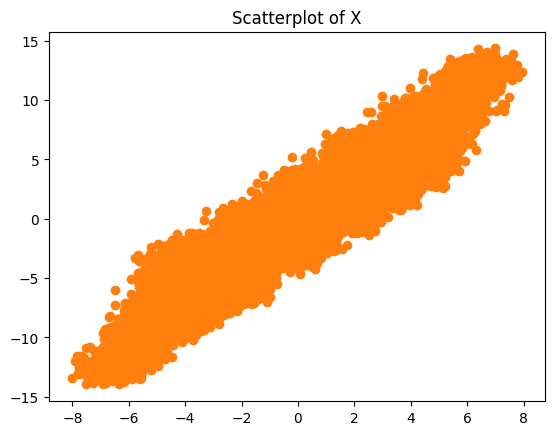

In [100]:
A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A values, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values
plt.title('Scatterplot of X')
plt.plot(X[0,:],X[1,:], 'C1o', zorder=0)

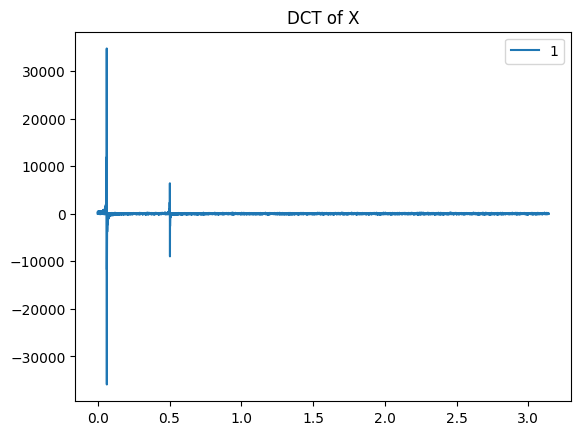

In [101]:
DCT = sff.dct(X)
plt.title("DCT of X")
plt.plot(np.linspace(0,np.pi,t),DCT[0,:],label='1')
plt.legend()
plt.show()

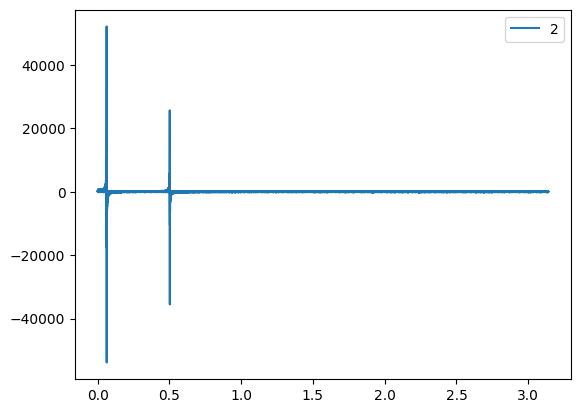

In [102]:
plt.plot(np.linspace(0,np.pi,t),DCT[1,:],label='2')
plt.legend()

**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?


**Answer:** The cost function we want to minimize is $\frac 1 2 ||X-AS||_F^2+\lambda||S||_1$ with relation to S. The first term is the mean squared error between X and its estimation AS (smooth) and the second term is a regularization term to prevent S from having too large parameters (not differentiable in 0). This function, while not differentiable because of the L1 norm is convex.

Compute the gradient along the S variable of the data-fidelity term.

**Answer:** The gradient of the data fidelity term is: $\nabla _S(\frac 1 2||X-AS||_F^2) = A^T(AS-X)$

Recall what the proximal operator of the l1-norm is.

**Answer:** The proximal operator of the l1 norm can be written as:\
$prox_{\lambda||.||_1}(S)_i = sign(s_i)*max(|s_i|-\lambda,0)$

In [56]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
def prox_l1(S_est,thrd):
    S_est = np.sign(S_est)*np.maximum(np.abs(S_est)-thrd,0)
    return S_est

Explain the main idea of the ISTA algorithm. Then, implement it.

In [68]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X,A = np.eye(2),n=2,lamb=0,nbIt = 100):
    S_est = np.zeros((n,X.shape[1]))
    gamma = 0.9/np.linalg.norm(A.T@A)
    for k in range(nbIt):
        S_est = prox_l1(S_est-gamma*A.T@(A@S_est-X),gamma*lamb)

    return S_est

It's now time to play with the code : launch the ISTA algorithm and look at the results.

Try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?

**Answer:** If we choose too high values ($ \lambda > 64715 $) then the DCT of the sources are completely null. On the other hand if we reduce $\lambda$ too much we could expect the signal to become noisy but even at $\lambda = 10^{-100}$ the noise is negligible and the frequencies are easily readable.

Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?

**Answer:** The signal is approximately sparse because exactly sparse signals aren't real.

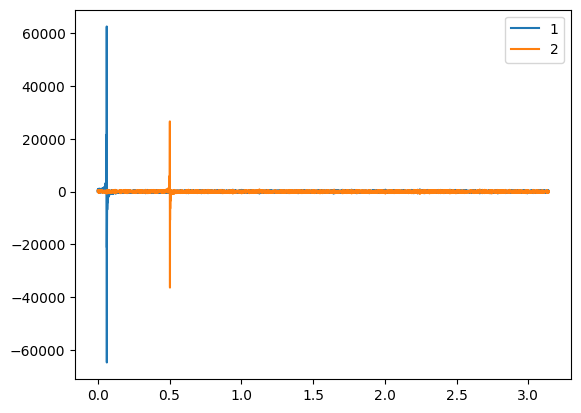

In [132]:
S_estdct = ISTA(DCT,A = A,n=2,lamb=1e-100,nbIt = 1000)
plt.plot(np.linspace(0,np.pi,t),S_estdct[0,:],label='1')
plt.plot(np.linspace(0,np.pi,t),S_estdct[1,:],label='2')
plt.legend()
plt.show()

Transform the sources back in the direct domain. Plot them. What do you see? Explain the differences with the original sources. Conclude.

**Answer:** The time domain sources look like the original ones but with some noise added to them because of the estimation error.

(-25.0, 25.0)

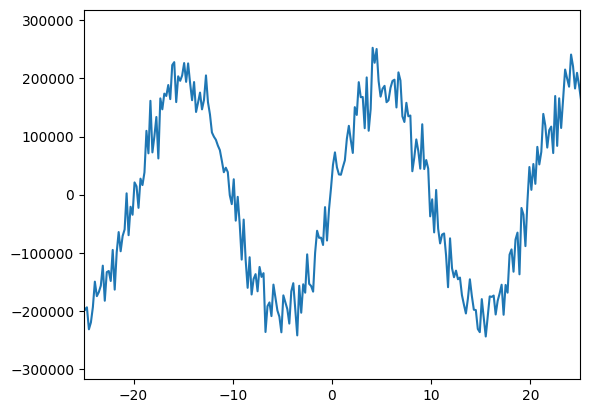

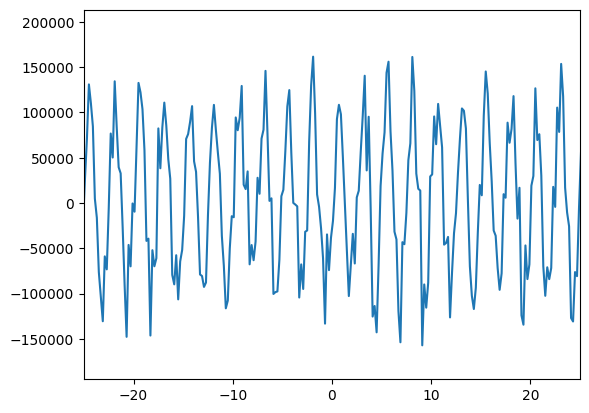

In [135]:
S_est = sff.idct(S_estdct)


plt.figure(),plt.plot(x_abs,S_est[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S_est[1,:])
plt.xlim([-25,25])

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?




**Answer:** We now want to minimize $\frac 1 2 ||X-AS||_F^2+\lambda||S||_1+\iota_{||A_{:,j}||^2<1}(A)$ with relation to A and S which is the same cost function as the last with an added oblique constraint which makes the whole function not convex.

Recall what the gradient of the data fidelity term over A is.

**Answer:** The gradient of the data fidelity term is: $\nabla _A(\frac 1 2||X-AS||_F^2) = (AS-X)S^T$

Compte the proximal operator of the oblique constraint. Implement it.

**Answer:** The proximal operator of the oblique constraint is the orthogonal projection of the matrix A on the space of matrices whose colums have norm less than 1.

In [136]:
def prox_oblique(A):
    for j in range(A.shape[1]):
        norm = np.linalg.norm(A[:,j])
        if norm >1:
            A[:,j] /= norm
    return A

Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [157]:
def PALM(X,n=2,lamb=0,nbIt = 100):
    m,t = X.shape
    A_est = np.random.rand(m,n)
    S_est = np.random.rand(n,t)
    for k in range(nbIt):
        gamma = 0.9/np.linalg.norm(A_est.T@A_est)
        eta = 0.9/np.linalg.norm(S_est@(S_est.T))
        S_est = prox_l1(S_est-gamma*(A_est.T)@(A_est@S_est-X),gamma*lamb)
        A_est = prox_oblique(A_est-eta*(A_est@S_est-X)@(S_est.T))

    return A_est,S_est

Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

[[0.75010502 0.42523364]
 [0.66131872 0.90508361]]
[[0.5547002  0.24253563]
 [0.83205029 0.9701425 ]]
0.10494353471889614


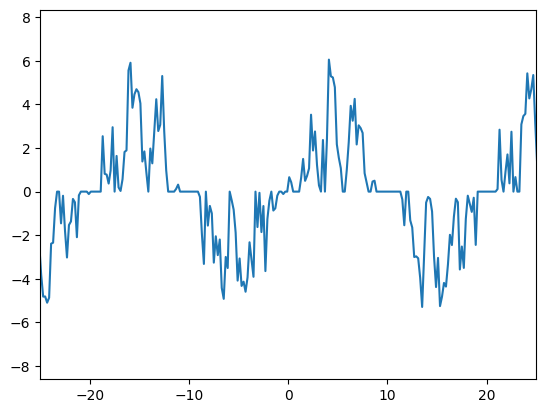

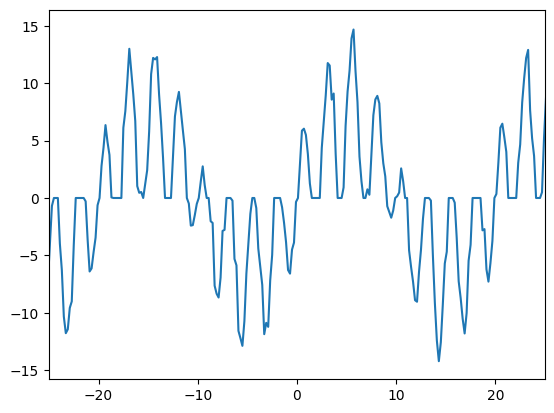

In [188]:
A_est,S_est = PALM(X,n=2,lamb=1,nbIt=1000)

plt.figure(),plt.plot(x_abs,S_est[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S_est[1,:])
plt.xlim([-25,25])
print(A_est)
print(A)
print(np.linalg.norm(A_est-A)**2)

The separation is pretty bad, we don't recognize the two signals and the square norm of the difference of A and its estimation varies between 10 and 40%.